# Modelo

In [11]:
!pip install librosa numpy scikit-learn keras

In [12]:
# Importación de librerías necesarias
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import os
import librosa
import numpy as np
from keras.utils import to_categorical

# Configuración
data_dir = '/content/drive/MyDrive/Tesis/mono_audios'
target_sampling_rate = 16000
n_mels = 128
fmax = 8000

# Variables para almacenar características y etiquetas
features = []
labels = []

# Parámetros de ruido gaussiano
mean = 0
std_dev = 0.001  # Ajusta este valor para controlar el nivel de ruido

# Procesar cada archivo de audio
for class_label in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_label)
    if os.path.isdir(class_path):  # Verificar que sea una carpeta
        for audio_file in os.listdir(class_path):
            audio_path = os.path.join(class_path, audio_file)
            if audio_path.endswith('.wav'):  # Procesar solo archivos .wav
                try:
                    # Cargar audio original
                    audio, _ = librosa.load(audio_path, sr=target_sampling_rate, mono=True)

                    # Generar Mel-espectrograma del audio original
                    spectrogram_original = librosa.feature.melspectrogram(y=audio, sr=target_sampling_rate, n_mels=n_mels, fmax=fmax)
                    spectrogram_original = librosa.power_to_db(spectrogram_original, ref=np.max)  # Convertir a dB

                    # Almacenar características y etiquetas del audio original
                    features.append(spectrogram_original)
                    labels.append(class_label)

                    # Aplicar ruido gaussiano al audio
                    noise = np.random.normal(mean, std_dev, audio.shape)
                    audio_noisy = audio + noise

                    # Generar Mel-espectrograma del audio con ruido
                    spectrogram_noisy = librosa.feature.melspectrogram(y=audio_noisy, sr=target_sampling_rate, n_mels=n_mels, fmax=fmax)
                    spectrogram_noisy = librosa.power_to_db(spectrogram_noisy, ref=np.max)  # Convertir a dB

                    # Almacenar características y etiquetas del audio con ruido
                    features.append(spectrogram_noisy)
                    labels.append(class_label)
                except Exception as e:
                    print(f"Error procesando archivo {audio_path}: {e}")

# Convertir a arrays de NumPy
features = np.array(features)
labels = np.array(labels)


In [15]:
print(noise)

[ 0.00098795 -0.00114932  0.00128818 ... -0.00027518 -0.00020857
  0.00010764]


In [16]:
np.savetxt('noise.txt', noise, delimiter=',')

In [17]:
# Convertir a arrays de NumPy
features = np.array(features)
labels = np.array(labels)

# Codificar etiquetas
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)  # Etiquetas numéricas
labels = to_categorical(labels)  # Codificación one-hot

# Dividir en entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Expandir dimensiones para redes convolucionales
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Mostrar información del dataset
print("Datos procesados correctamente.")
print(f"Forma de X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Forma de X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Forma de X_test: {X_test.shape}, y_test: {y_test.shape}")


Datos procesados correctamente.
Forma de X_train: (1712, 128, 63, 1), y_train: (1712, 5)
Forma de X_val: (214, 128, 63, 1), y_val: (214, 5)
Forma de X_test: (214, 128, 63, 1), y_test: (214, 5)


# Arquitectura del modelo

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Definir el modelo
model = Sequential([
    # Primera capa convolucional
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 63, 1)),
    MaxPooling2D((2, 2)),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Tercera capa convolucional
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Aplanar las características
    Flatten(),

    # Capa densa
    Dense(128, activation='relu'),
    Dropout(0.5),  # Regularización para prevenir sobreajuste

    # Capa de salida
    Dense(5, activation='softmax')  # 5 clases, activación softmax
])

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 61, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 6, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 10752)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,376,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,469,701 (5.61 MB)

 Trainable params: 1,469,701 (5.61 MB)

 Non-trainable params: 0 (0.00 B)

# Entrenar el modelo

In [19]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# Definir EarlyStopping para detener el entrenamiento si la validación no mejora
early_stopping = EarlyStopping(
    monitor='val_loss',  # Supervisar la pérdida en el conjunto de validación
    patience=5,  # Número de épocas sin mejora antes de detener
    restore_best_weights=True  # Restaurar los pesos del mejor modelo
)

# Definir ReduceLROnPlateau para reducir el learning rate si el modelo se estanca
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Supervisar la pérdida en el conjunto de validación
    factor=0.1,  # Reducir el learning rate por un factor de 10
    patience=3,  # Número de épocas sin mejora antes de reducir
    min_lr=1e-6  # Learning rate mínimo
)

# Definir ModelCheckpoint con la extensión correcta
model_checkpoint = ModelCheckpoint(
    'best_model.keras',  # Cambiado a .keras
    monitor='val_loss',  # Supervisar la pérdida en el conjunto de validación
    save_best_only=True  # Guardar solo si el modelo mejora
)

# Definir TensorBoard para visualizar métricas en TensorBoard
tensorboard_callback = TensorBoard(
    log_dir='./logs',  # Carpeta donde se guardarán los logs
    histogram_freq=1,  # Guardar histogramas de pesos cada 1 época
    write_graph=True  # Guardar el grafo computacional
)

In [20]:
# Compilar el modelo con un learning rate inicial
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)  # Definir el learning rate inicial
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con los callbacks definidos
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,  # Número de épocas ajustable
    batch_size=32,  # Tamaño del lote
    verbose=1,  # Mostrar progreso durante el entrenamiento
    callbacks=[early_stopping, model_checkpoint, reduce_lr, tensorboard_callback]  # Callbacks
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 510ms/step - accuracy: 0.2987 - loss: 3.1390 - val_accuracy: 0.6449 - val_loss: 1.1913 - learning_rate: 1.0000e-04
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 499ms/step - accuracy: 0.4928 - loss: 1.2241 - val_accuracy: 0.7664 - val_loss: 0.9289 - learning_rate: 1.0000e-04
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 538ms/step - accuracy: 0.6161 - loss: 0.9787 - val_accuracy: 0.7804 - val_loss: 0.6787 - learning_rate: 1.0000e-04
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 525ms/step - accuracy: 0.7010 - loss: 0.7885 - val_accuracy: 0.8598 - val_loss: 0.4997 - learning_rate: 1.0000e-04
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 483ms/step - accuracy: 0.7502 - loss: 0.6800 - val_accuracy: 0.8598 - val_loss: 0.4478 - learning_rate: 1.0000e-04
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 527ms/step - accuracy: 0.7796 - loss: 0.6193 - val_accuracy: 0.8738 - val_loss: 0.3805 - learning_rate: 1.0000e-04
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 521ms/step - acc

# Evaluar el modelo

In [21]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Pérdida en el conjunto de prueba: {test_loss}")
print(f"Precisión en el conjunto de prueba: {test_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.9774 - loss: 0.0514
Pérdida en el conjunto de prueba: 0.07051965594291687
Precisión en el conjunto de prueba: 0.9719626307487488


In [22]:
y_true_labels = np.argmax(y_test, axis=1)
predictions = model.predict(X_test)  # Probabilidades predichas
y_pred_labels = np.argmax(predictions, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


In [23]:
class_names = label_encoder.classes_

In [24]:
from sklearn.metrics import classification_report
# Generar el reporte de clasificación
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)
print("Reporte de Clasificación:")
print(report)

Reporte de Clasificación:
                precision    recall  f1-score   support

        crying       0.95      0.95      0.95        42
glass_breaking       0.98      0.98      0.98        43
      gun_shot       0.95      0.98      0.97        43
people_talking       1.00      1.00      1.00        43
       screams       0.98      0.95      0.96        43

      accuracy                           0.97       214
     macro avg       0.97      0.97      0.97       214
  weighted avg       0.97      0.97      0.97       214



# Visualizar el entrenamiento

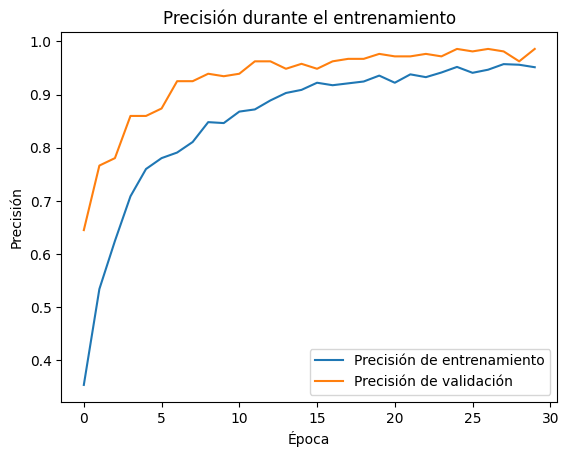

In [25]:
import matplotlib.pyplot as plt

# Gráfica de la precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión durante el entrenamiento')
plt.show()

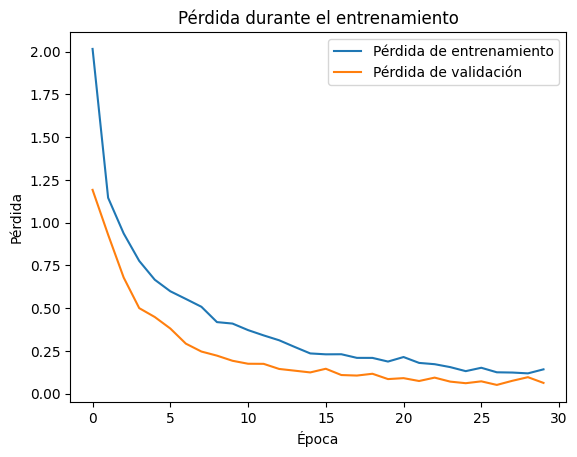

In [26]:
# Gráfica de la pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida durante el entrenamiento')
plt.show()

# Distribución de probabilidad en softmax

In [27]:
# Promedio de probabilidades para cada clase
mean_probabilities = np.mean(predictions, axis=0)
class_probabilities = dict(zip(class_names, mean_probabilities))

print("Distribución promedio de probabilidades por clase:")
for class_name, probability in class_probabilities.items():
    print(f"{class_name}: {probability:.4f}")

# Promedio de la probabilidad máxima para cada muestra (confianza promedio del modelo)
average_max_probability = np.mean(np.max(predictions, axis=1))
print(f"Confianza promedio del modelo (probabilidad máxima por muestra): {average_max_probability:.4f}")


Distribución promedio de probabilidades por clase:
crying: 0.2003
glass_breaking: 0.1983
gun_shot: 0.2056
people_talking: 0.1982
screams: 0.1977
Confianza promedio del modelo (probabilidad máxima por muestra): 0.9724


In [28]:
# Analizar y graficar las probabilidades para las primeras 5 muestras
for i in range(5):  # Cambia el rango según el número de muestras que desees analizar
    # Imprimir las probabilidades en consola
    print(f"Muestra {i+1}:")
    for class_name, prob in zip(class_names, predictions[i]):
        print(f"  {class_name}: {prob:.4f}")
    print()  # Línea en blanco entre muestras

    # Mostrar el gráfico
    plt.show()


Muestra 1:
  crying: 0.0000
  glass_breaking: 0.9996
  gun_shot: 0.0003
  people_talking: 0.0000
  screams: 0.0001

Muestra 2:
  crying: 0.0000
  glass_breaking: 0.0000
  gun_shot: 0.0000
  people_talking: 1.0000
  screams: 0.0000

Muestra 3:
  crying: 0.0007
  glass_breaking: 0.0000
  gun_shot: 0.0000
  people_talking: 0.0000
  screams: 0.9993

Muestra 4:
  crying: 0.0063
  glass_breaking: 0.0258
  gun_shot: 0.9557
  people_talking: 0.0029
  screams: 0.0093

Muestra 5:
  crying: 0.9973
  glass_breaking: 0.0000
  gun_shot: 0.0000
  people_talking: 0.0000
  screams: 0.0027



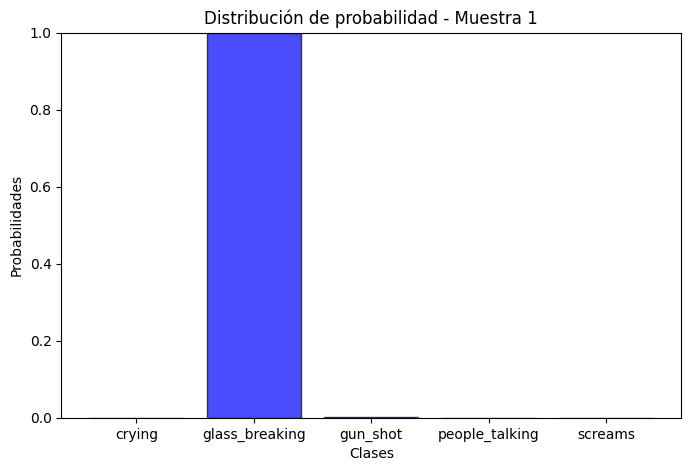

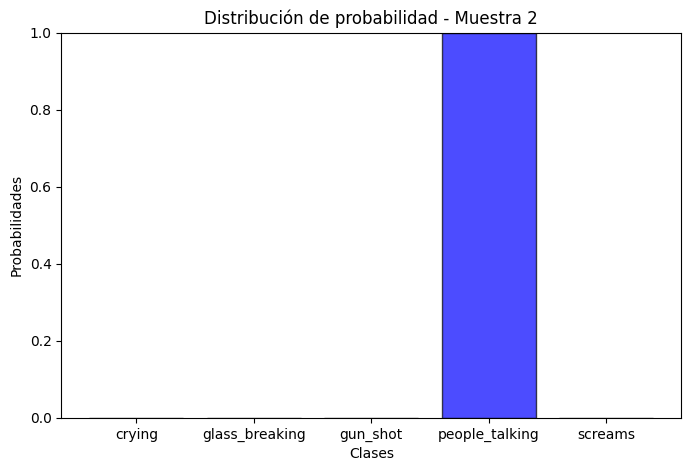

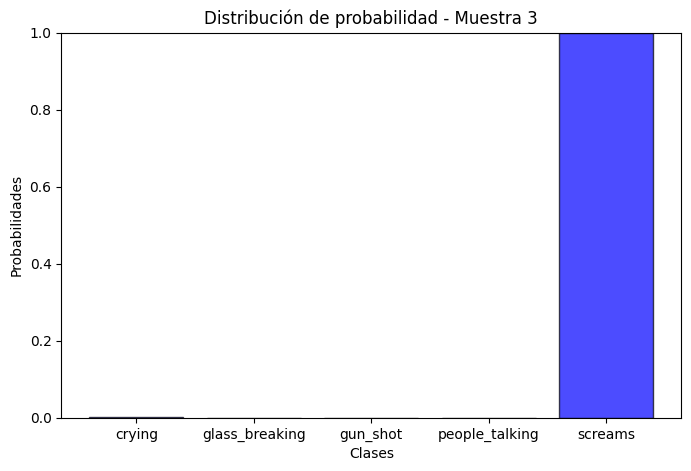

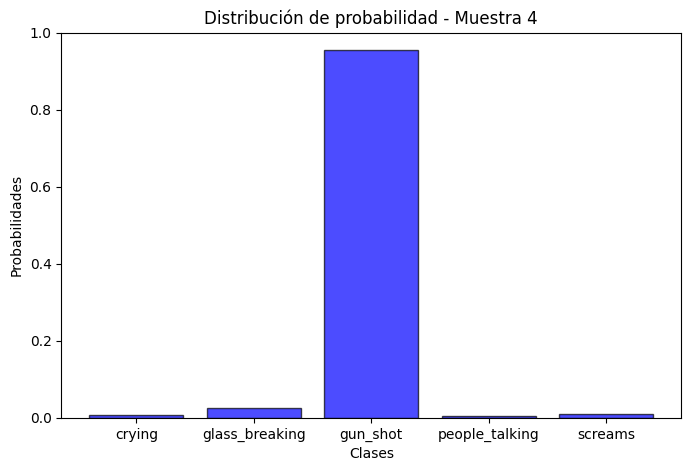

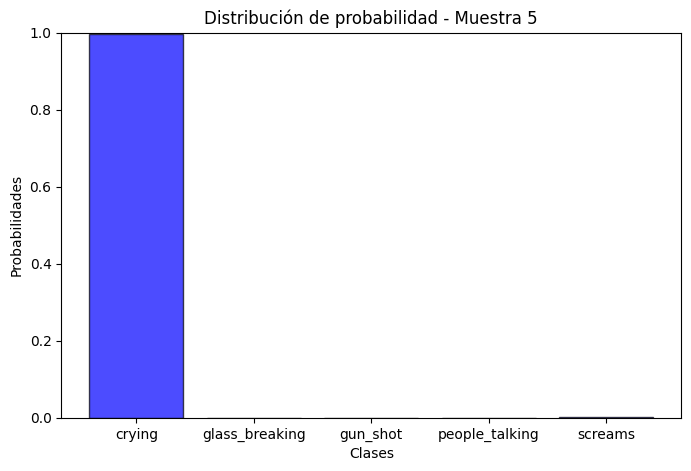

In [29]:
# Analizar y graficar las probabilidades para las primeras 5 muestras
for i in range(5):  # Cambia el rango según el número de muestras que desees analizar
    plt.figure(figsize=(8, 5))
    plt.bar(class_names, predictions[i], alpha=0.7, color='blue', edgecolor='black')
    plt.title(f"Distribución de probabilidad - Muestra {i+1}")
    plt.xlabel('Clases')
    plt.ylabel('Probabilidades')
    plt.ylim(0, 1)
    plt.show()

# Divergencia de Kullback-Leibler (KL Divergence)

In [30]:
from scipy.stats import entropy
import numpy as np

# Calcular KL Divergence para cada muestra
kl_divergences = [
    entropy(y_test[i], predictions[i]) for i in range(len(y_test))
]

# Promedio de KL Divergence
average_kl_divergence = np.mean(kl_divergences)
print(f"Divergencia KL promedio en el conjunto de prueba: {average_kl_divergence:.4f}")


Divergencia KL promedio en el conjunto de prueba: 0.0705


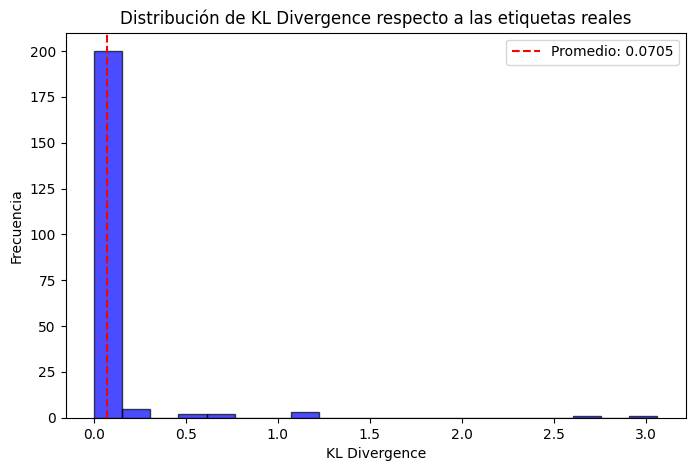

In [31]:
# Graficar la distribución de KL Divergence
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(kl_divergences, bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title("Distribución de KL Divergence respecto a las etiquetas reales")
plt.xlabel("KL Divergence")
plt.ylabel("Frecuencia")
plt.axvline(average_kl_divergence, color='red', linestyle='--', label=f"Promedio: {average_kl_divergence:.4f}")
plt.legend()
plt.show()


### Comparar contra una distribución uniforme

Divergencia KL promedio respecto a la uniforme: 1.5259


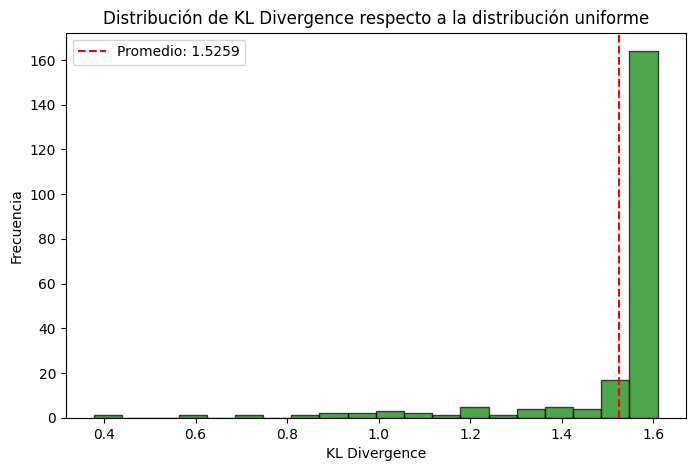

In [32]:
# Crear una distribución uniforme de referencia
uniform_distribution = np.ones(predictions.shape[1]) / predictions.shape[1]  # Ejemplo: [0.2, 0.2, 0.2, 0.2, 0.2]

# Calcular KL Divergence para cada muestra respecto a la uniforme
kl_divergence_uniform = [
    entropy(predictions[i], uniform_distribution) for i in range(len(predictions))
]

# Promedio de KL Divergence respecto a la uniforme
average_kl_uniform = np.mean(kl_divergence_uniform)
print(f"Divergencia KL promedio respecto a la uniforme: {average_kl_uniform:.4f}")

# Graficar la distribución de KL Divergence respecto a la uniforme
plt.figure(figsize=(8, 5))
plt.hist(kl_divergence_uniform, bins=20, alpha=0.7, color='green', edgecolor='black')
plt.title("Distribución de KL Divergence respecto a la distribución uniforme")
plt.xlabel("KL Divergence")
plt.ylabel("Frecuencia")
plt.axvline(average_kl_uniform, color='red', linestyle='--', label=f"Promedio: {average_kl_uniform:.4f}")
plt.legend()
plt.show()


# Matriz de confusión

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Convertir las predicciones a etiquetas
y_pred_labels = np.argmax(predictions, axis=1)  # Etiquetas predichas
y_true_labels = np.argmax(y_test, axis=1)       # Etiquetas reales

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Imprimir la matriz de confusión
print("Matriz de confusión:")
print(conf_matrix)

# Etiquetas de las clases
class_names = label_encoder.classes_  # Nombres de las clases


Matriz de confusión:
[[40  0  1  0  1]
 [ 0 42  1  0  0]
 [ 0  1 42  0  0]
 [ 0  0  0 43  0]
 [ 2  0  0  0 41]]


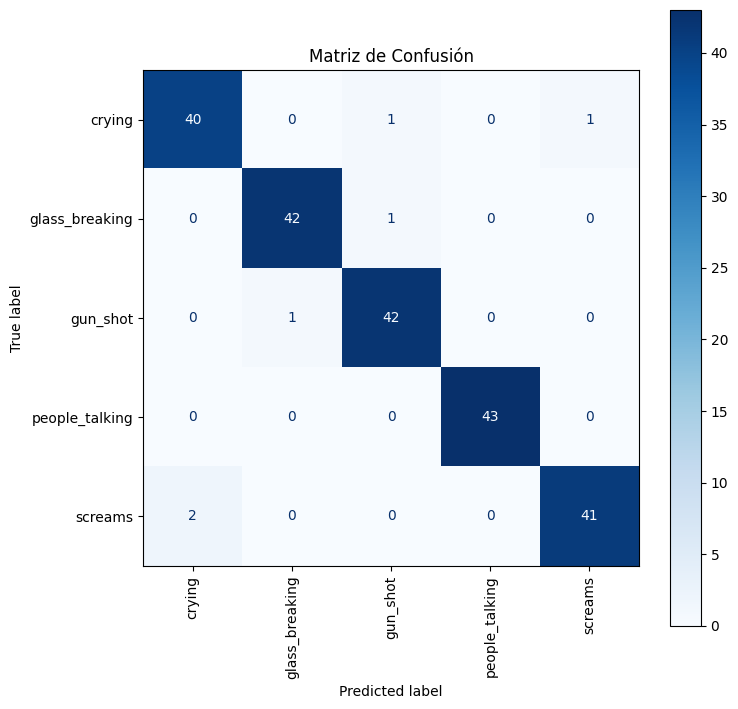

In [34]:
# Graficar la matriz de confusión
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=plt.gca())
plt.title("Matriz de Confusión")
plt.show()


# Guardar el modelo entrenado

In [35]:
model.save('audio_classification_model.h5')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


# Predecir con el modelo

In [36]:
import librosa
import numpy as np

def preprocess_audio_segment(segment, sr=16000, n_mels=128, fmax=8000):
    """Generar el Mel-espectrograma de un segmento de audio."""
    # Calcular Mel-espectrograma
    spectrogram = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=n_mels, fmax=fmax)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    # Expandir dimensiones para el modelo
    spectrogram_db = spectrogram_db[..., np.newaxis]
    return spectrogram_db

def predict_long_audio_with_labels(model, audio_path, labels, segment_duration=2, sr=16000):
    """Predecir un audio largo dividiéndolo en cortes y mostrando probabilidades con etiquetas."""
    # Cargar el audio completo
    audio, _ = librosa.load(audio_path, sr=sr, mono=True)

    # Longitud en muestras de cada segmento
    segment_samples = int(segment_duration * sr)

    # Dividir el audio en segmentos de 2 segundos
    segments = [
        audio[i:i + segment_samples]
        for i in range(0, len(audio), segment_samples)
        if len(audio[i:i + segment_samples]) == segment_samples
    ]

    # Generar características (Mel-espectrogramas) para cada segmento
    features = np.array([preprocess_audio_segment(segment, sr) for segment in segments])

    # Realizar predicciones para cada segmento (probabilidades)
    predictions = model.predict(features)  # Salida: probabilidades

    # Mostrar las probabilidades con etiquetas para cada segmento
    for i, probs in enumerate(predictions):
        print(f"Segmento {i + 1}:")
        for label, prob in zip(labels, probs):
            print(f"   {label}: {prob * 100:.2f}%")

    return predictions

labels = ['crying', 'glass_breaking', 'gun_shot','people_talking', 'screams']

# Ruta de un audio largo
#audio_path = "/content/drive/MyDrive/tesis colab/audio tests/3 hablando.WAV"
#audio_path = "/content/drive/MyDrive/tesis colab/audio tests/1 Balas.WAV"
#audio_path = "/content/drive/MyDrive/tesis colab/audio tests/2 Gritos.WAV"
#audio_path = "/content/drive/MyDrive/tesis colab/audio tests/4 vidrio.WAV"
audio_path = "/content/drive/MyDrive/tesis colab/audio tests/5 Llanto.WAV"

# Predecir el audio largo
predictions = predict_long_audio_with_labels(model, audio_path, labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Segmento 1:
   crying: 100.00%
   glass_breaking: 0.00%
   gun_shot: 0.00%
   people_talking: 0.00%
   screams: 0.00%
Segmento 2:
   crying: 100.00%
   glass_breaking: 0.00%
   gun_shot: 0.00%
   people_talking: 0.00%
   screams: 0.00%
Segmento 3:
   crying: 100.00%
   glass_breaking: 0.00%
   gun_shot: 0.00%
   people_talking: 0.00%
   screams: 0.00%
Segmento 4:
   crying: 99.98%
   glass_breaking: 0.00%
   gun_shot: 0.00%
   people_talking: 0.00%
   screams: 0.02%
Segmento 5:
   crying: 99.90%
   glass_breaking: 0.00%
   gun_shot: 0.00%
   people_talking: 0.00%
   screams: 0.10%


In [37]:
import pandas as pd

# Define the training results data
data = {
    "epoch": list(range(1, 21)),
    "accuracy": [
        0.2137, 0.3944, 0.4759, 0.5254, 0.5838, 0.6332, 0.6945, 0.7148,
        0.7637, 0.7118, 0.7837, 0.8190, 0.8389, 0.8086, 0.8699, 0.8496,
        0.8865, 0.8994, 0.8864, 0.8897
    ],
    "val_accuracy": [
        0.4953, 0.5047, 0.7009, 0.6916, 0.6916, 0.7383, 0.7850, 0.7944,
        0.7196, 0.8224, 0.8411, 0.8785, 0.8411, 0.8692, 0.8411, 0.8318,
        0.8692, 0.8411, 0.8692, 0.8879
    ],
    "val_loss": [
        1.4416, 1.2827, 1.0692, 0.9601, 0.8783, 0.7645, 0.6673, 0.6255,
        0.6702, 0.5266, 0.4730, 0.4409, 0.3939, 0.4085, 0.4484, 0.3727,
        0.3430, 0.3823, 0.3243, 0.3283
    ]
}

# Convert to a DataFrame
df = pd.DataFrame(data)

# Save to an Excel file
file_path = "training_results.xlsx"
df.to_excel(file_path, index=False)

file_path


'training_results.xlsx'